In [4]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Função para obter o token de acesso
def get_token():
    url = "https://www.ana.gov.br/hidrowebservice/EstacoesTelemetricas/OAUth/v1"
    
    headers = {
        "accept": "*/*",
        "Identificador": "LOGIN",  # Substitua com o seu identificador
        "Senha": "SENHA"  # Substitua com a sua senha
        # O loguin e senha foram subistiruido para segurança
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Retorna o token de autenticação
        data = response.json()
        token = data["items"]["tokenautenticacao"]
        return token
    else:
        raise Exception(f"Erro ao obter token: {response.status_code}, {response.text}")

# Função para fazer o download dos dados de uma estação
def baixar_dados(codigo_estacao, data_inicio, data_fim, token):
    url = f"https://www.ana.gov.br/hidrowebservice/EstacoesTelemetricas/HidroinfoanaSerieTelemetricaAdotada/v1"
    
    params = {
        'Código da Estação': codigo_estacao,
        'Tipo Filtro Data': 'DATA_LEITURA',
        'Data de Busca (yyyy-MM-dd)': data_inicio.strftime('%Y-%m-%d'),
        'Range Intervalo de busca': 'HORA_24'  # Ajuste para resolução horária
    }
    
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Erro ao baixar dados da estação {codigo_estacao}: {response.status_code}")
        return None

# Função para baixar e filtrar os dados por estação
def baixar_e_filtrar_estacao(codigo_estacao, inicio, fim):
    token = get_token()  # Obter o token de autenticação
    df_estacao = pd.DataFrame()  # Dataframe vazio para a estação específica
    
    data_atual = inicio
    while data_atual <= fim:
        data_fim = min(data_atual + timedelta(days=1), fim)
        dados = baixar_dados(codigo_estacao, data_atual, data_fim, token)
        
        if dados:
            df_temp = pd.DataFrame(dados['items'])
            df_estacao = pd.concat([df_estacao, df_temp])  # Adiciona os dados ao dataframe da estação
            
        data_atual = data_fim + timedelta(seconds=1)
    
    return df_estacao

# Função principal para baixar os dados de várias estações
def baixar_dados_varias_estacoes(estacoes, inicio, fim):
    for estacao in estacoes:
        df_estacao = baixar_e_filtrar_estacao(estacao, inicio, fim)
        
        # Salvar cada estação em um arquivo CSV separado
        df_estacao.to_csv(f'dados_estacao_{estacao}.csv', index=False)
        print(f"Dados da estação {estacao} salvos no arquivo dados_estacao_{estacao}.csv")

# Definir as estações e o período para download
estacoes = ['86520100']  # Lista de códigos de estações
data_inicio = datetime(2024, 1, 1)
data_fim = datetime(2024, 9, 1)  # Um pequeno período para teste

# Baixar os dados de várias estações
baixar_dados_varias_estacoes(estacoes, data_inicio, data_fim)


Dados da estação 86520100 salvos no arquivo dados_estacao_86520100.csv


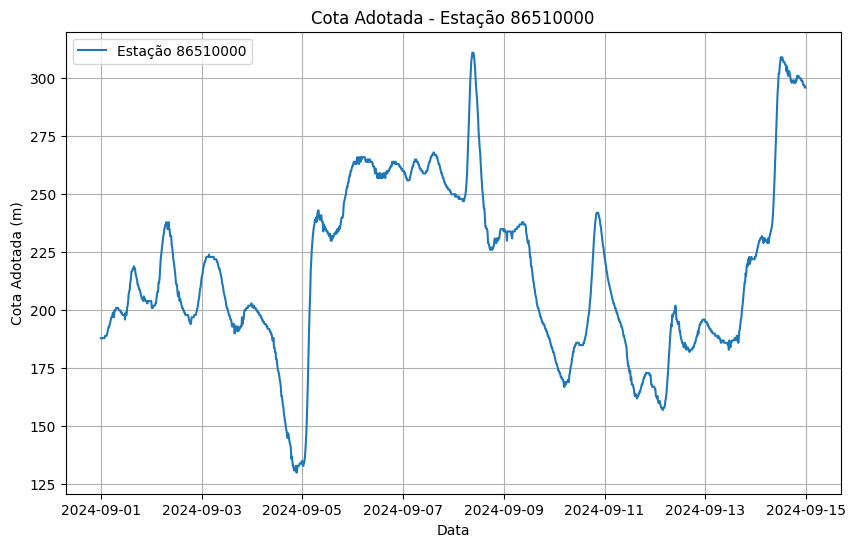

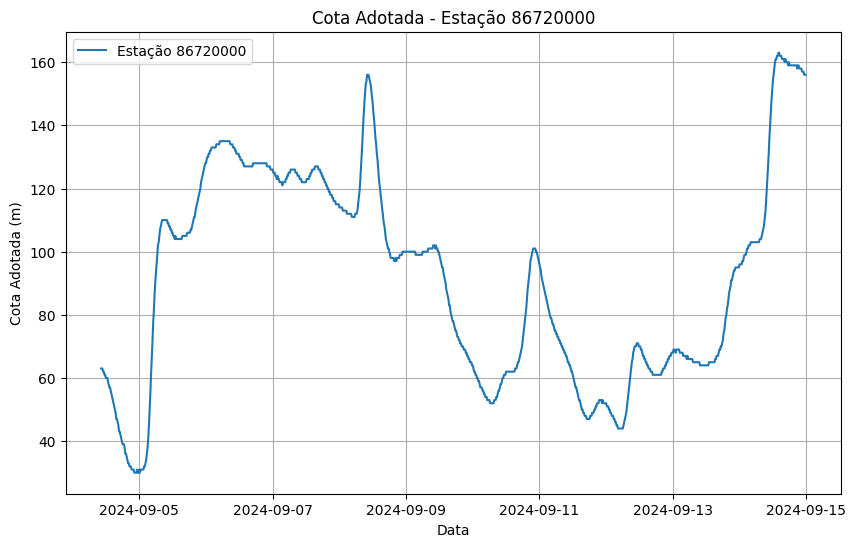

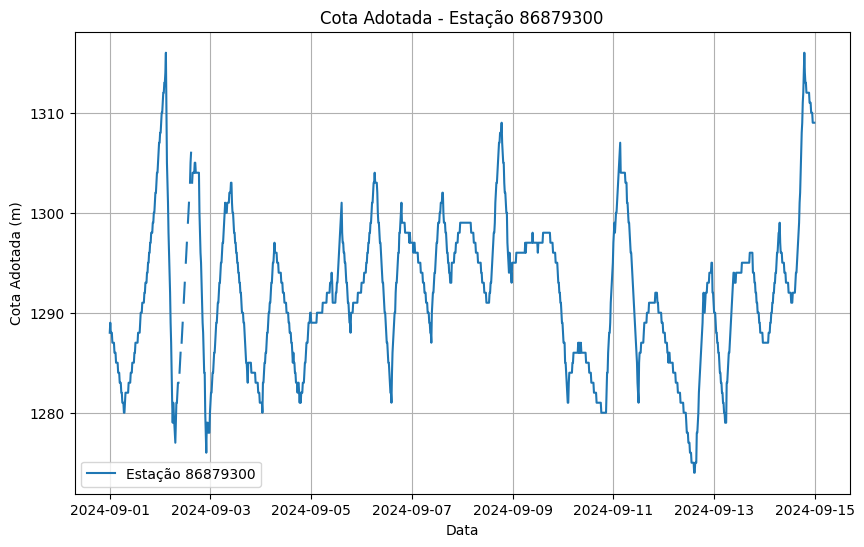

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para carregar e plotar os dados de Cota_Adotada de uma estação
def plotar_cota_adotada(nome_arquivo, codigo_estacao):
    # Carregar os dados do CSV
    df = pd.read_csv(nome_arquivo)
    
    # Converter a coluna 'Data_Hora_Medicao' para o formato datetime
    df['Data_Hora_Medicao'] = pd.to_datetime(df['Data_Hora_Medicao'])

    # Ordenar o dataframe pela coluna Data_Hora_Medicao
    df = df.sort_values(by='Data_Hora_Medicao')
    
    # Plotar o gráfico da Cota_Adotada
    plt.figure(figsize=(10, 6))
    plt.plot(df['Data_Hora_Medicao'], df['Cota_Adotada'], label=f'Estação {codigo_estacao}')
    
    # Ajustes no gráfico
    plt.title(f'Cota Adotada - Estação {codigo_estacao}')
    plt.xlabel('Data')
    plt.ylabel('Cota Adotada (m)')
    plt.legend()
    plt.grid(True)
    
    # Exibir o gráfico
    plt.show()

# Plotar os gráficos para cada estação
plotar_cota_adotada('dados_estacao_86510000.csv', '86510000')
plotar_cota_adotada('dados_estacao_86720000.csv', '86720000')
plotar_cota_adotada('dados_estacao_86879300.csv', '86879300')
